In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - "03_26_24_RandomCircles_MixedEnsembleStrategies"
    
# log_attributes:
#     03_26_24_RandomCircles_MixedEnsembleStrategies:
#         loss_func: "CE"

calibration:
    metric_cfg_file: "/storage/vbutoi/projects/ESE/ese/experiment/configs/inference/Calibration_Metrics.yaml"

options:
    add_baseline_rows: True  
    load_pixel_meters: False 
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    load_groupavg_metrics: False
    remove_shared_columns: False
    equal_rows_per_cfg_assert: True 

<IPython.core.display.Javascript object>

In [3]:
from ese.experiment.analysis.analyze_inf import load_cal_inference_stats

image_info_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Error loading result log file: Found non-success result in file /storage/vbutoi/scratch/ESE/inference/03_26_24_RandomCircles_MixedEnsembleStrategies/Shapes_Ensemble_LTS/submitit/734343_0_result.pkl: error.
Error loading result log file: Found non-success result in file /storage/vbutoi/scratch/ESE/inference/03_26_24_RandomCircles_MixedEnsembleStrategies/Shapes_Ensemble_TempScaling/submitit/958128_0_result.pkl: error.
[Errno 2] No such file or directory: '/storage/vbutoi/scratch/ESE/inference/03_26_24_RandomCircles_MixedEnsembleStrategies/Shapes_Ensemble_LTS/20240326_162442-4I95-b56a4a1e4c34ec6b1d3ed54497509a35/image_stats.pkl'. Skipping.
[Errno 2] No such file or directory: '/storage/vbutoi/scratch/ESE/inference/03_26_24_RandomCircles_MixedEnsembleStrategies/Shapes_Ensemble_TempScaling/20240326_181343-TAD5-4670554d94edd227f41c54a0b13500f1/image_stats.pkl'. Skipping.
Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 386289 -> 386289 rows.
Finished loading inference s

In [4]:
image_info_df['calibrator'].unique()

array(['LTS', 'Uncalibrated', 'TempScaling', 'Average'], dtype=object)

In [5]:
# Sort the image_info_df by method name, so everything appears nicely
image_info_df = image_info_df.sort_values(by=['method_name', 'calibrator'])
# Make sure that the model_class 'Uncalibrated' is first
image_info_df['calibrator'] = image_info_df['calibrator'].astype('category')
image_info_df['calibrator'] = image_info_df['calibrator'].cat.reorder_categories([
    'Average',
    'Uncalibrated',
    'TempScaling', 
    'LTS'
])

In [6]:
# Select only the rows corresponding to group methods
image_info_df = image_info_df[image_info_df['model_type'] == 'group']

In [7]:
image_info_df['method_name'].unique()

array(['Average UNet', 'Ensemble (max, probs)', 'Ensemble (mean, logits)',
       'Ensemble (mean, probs)'], dtype=object)

In [8]:
image_info_df['method_name'] = image_info_df['method_name'].astype('category')
image_info_df['method_name'] = image_info_df['method_name'].cat.reorder_categories([
    'Average UNet',
    'Ensemble (mean, probs)',
    'Ensemble (mean, logits)',
    'Ensemble (max, probs)',
])

image_info_df['split'] = image_info_df['split'].astype('category')
image_info_df['split'] = image_info_df['split'].cat.reorder_categories([
    'val',
    'cal'
])

## ECE Metrics

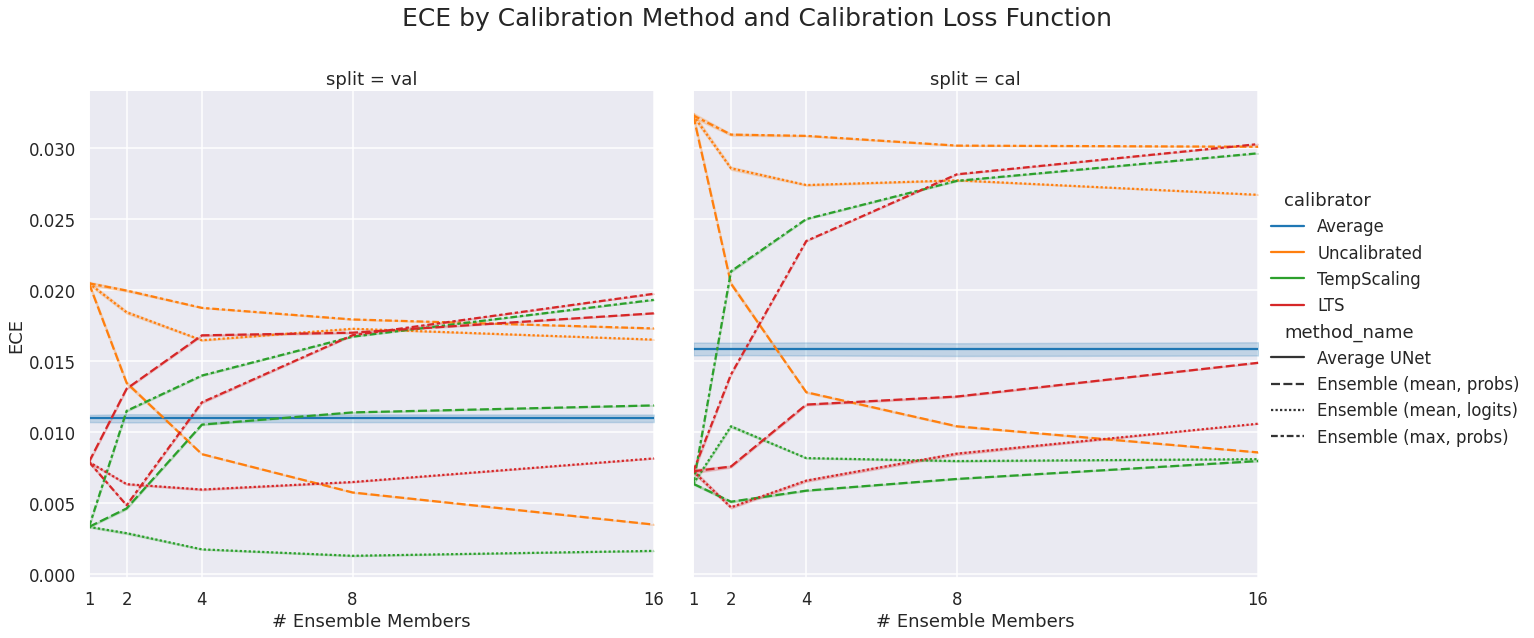

In [9]:
g = sns.relplot(
    data=image_info_df,
    x="num_ensemble_members",
    y="ECE",
    hue="calibrator",
    style="method_name",
    col="split",
    kind="line",
    height=9,
)
g.fig.suptitle("ECE by Calibration Method and Calibration Loss Function", fontsize=25)
g.set_xlabels("# Ensemble Members")
g.fig.subplots_adjust(top=0.85)
g.set(xticks=[1, 2, 4, 8, 16])
g.set(xlim=(1, 16))
# Separate the columns slightly
g.fig.subplots_adjust(wspace=0.07)

In [10]:
def group_by_config(in_df):
    grouped_df = in_df.groupby([
        'ensemble_hash',
        'method_name',
        'calibrator',
        'split',
        'num_ensemble_members',
        'image_metric'
    ])
    # Mean over the metric_score columns
    meaned_groups =  grouped_df.agg({'metric_score': 'mean'}).reset_index()
    # Drop the NaN rows
    grouped_cfg = meaned_groups.dropna().reset_index(drop=True)
    return grouped_cfg

In [11]:
image_info_df['image_metric'].unique()

array(['Accuracy', 'BoundaryIOU', 'Dice', 'HD95', 'Hard-Region-Ambiguity',
       'Image_CW-ECE', 'Image_ECE', 'Image_ECW-ECE', 'Image_ELM',
       'Image_Edge-ECE', 'Image_Edge-ELM', 'Image_Uniform-CW-ECE',
       'Image_Uniform-ECW-ECE', 'Image_Uniform-ELM',
       'Image_Uniform-Edge-ELM', 'Pixel-Ambiguity', 'Precision', 'Recall',
       'Soft-Region-Ambiguity', 'Dice Loss'], dtype=object)

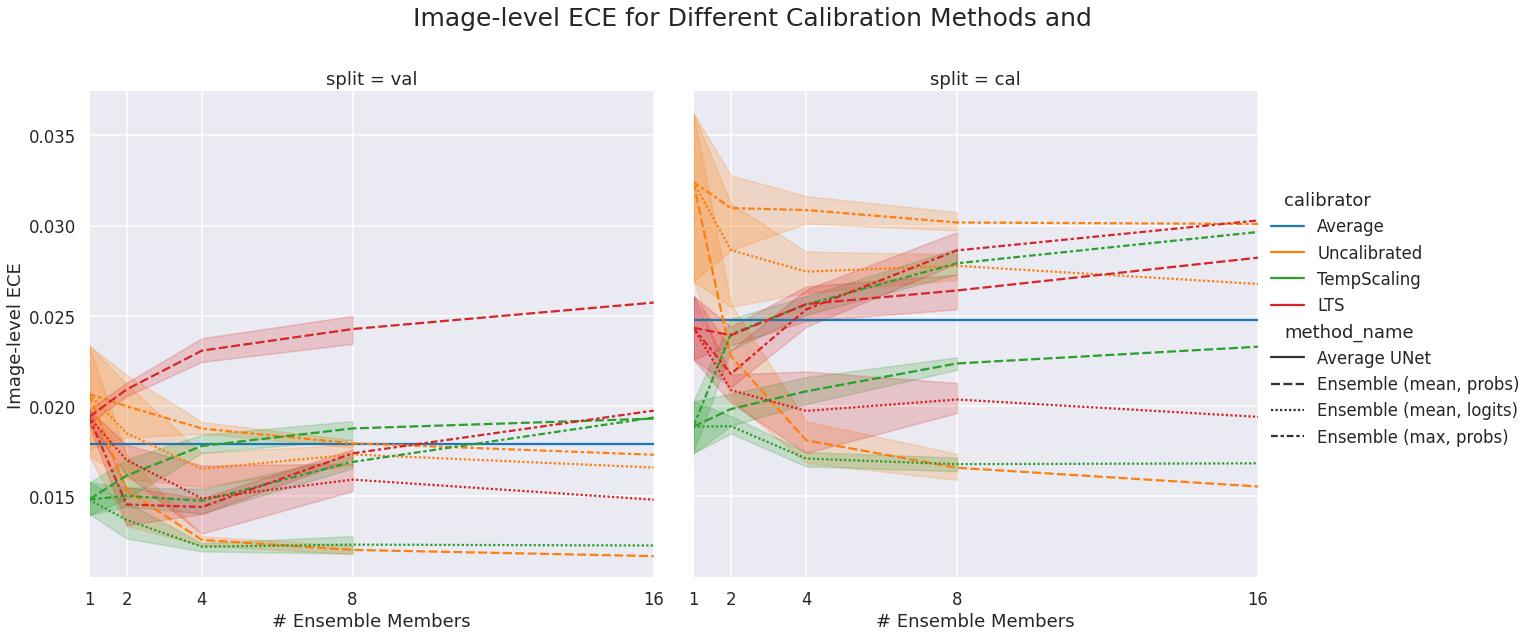

In [12]:
ece_metric_df = group_by_config(image_info_df[image_info_df['image_metric'] == 'Image_ECE'])

g = sns.relplot(
    data=ece_metric_df,
    x="num_ensemble_members",
    y="metric_score",
    hue="calibrator",
    style="method_name",
    kind="line",
    col="split",
    height=9,
)
# Set the title of the bar plot
g.fig.suptitle("Image-level ECE for Different Calibration Methods and ", fontsize=25)
g.fig.subplots_adjust(top=0.85)
# Separate the columns slightly
g.fig.subplots_adjust(wspace=0.07)
# Change the y axis label to say ECEkjkj
g.set_ylabels("Image-level ECE")
g.set_xlabels("# Ensemble Members")
g.set(xlim=(1, 16))
g.set(xticks=[1, 2, 4, 8, 16])

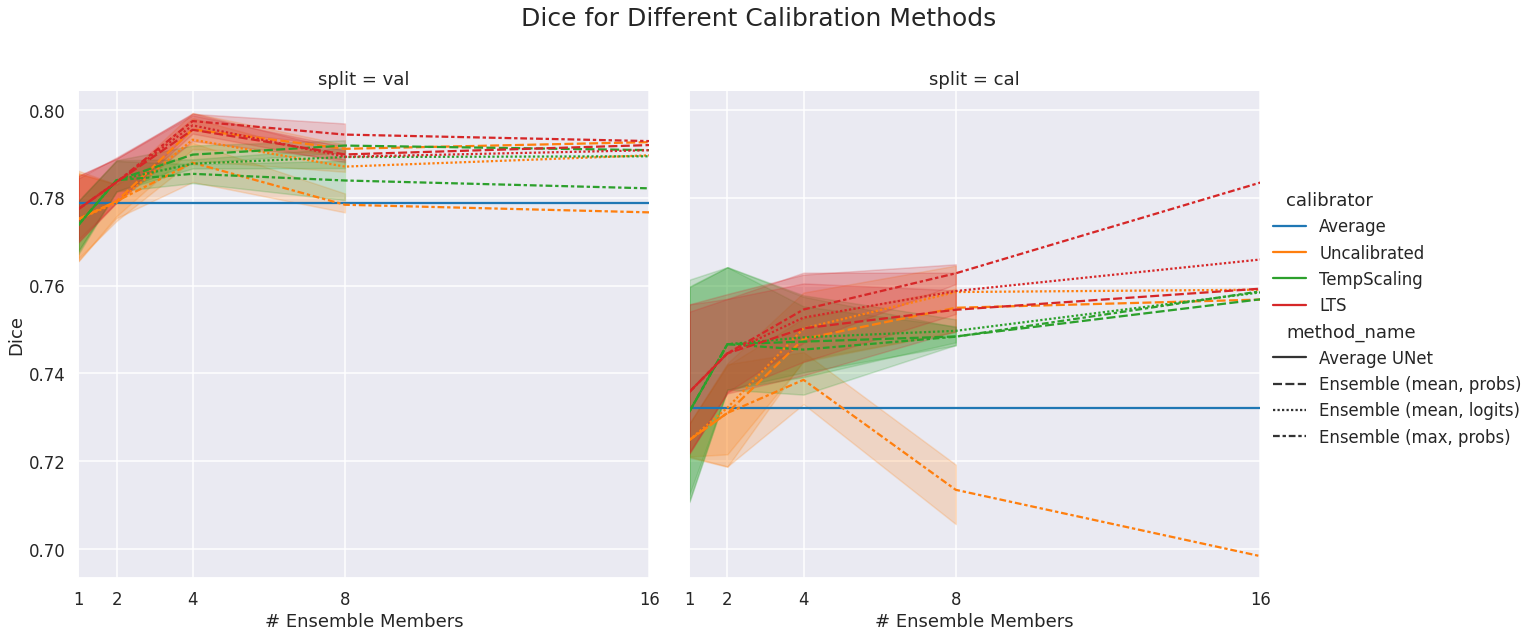

In [13]:
dice_metric_df = group_by_config(image_info_df[image_info_df['image_metric'] == 'Dice'])

g = sns.relplot(
    data=dice_metric_df,
    x="num_ensemble_members",
    y="metric_score",
    hue="calibrator",
    style="method_name",
    kind="line",
    col="split",
    height=9,
)
# Set the title of the bar plot
g.fig.suptitle("Dice for Different Calibration Methods", fontsize=25)
g.fig.subplots_adjust(top=0.85)
# Separate the columns slightly
g.fig.subplots_adjust(wspace=0.07)
# Change the y axis label
g.set_ylabels("Dice")
g.set_xlabels("# Ensemble Members")
g.set(xlim=(1, 16))
g.set(xticks=[1, 2, 4, 8, 16])

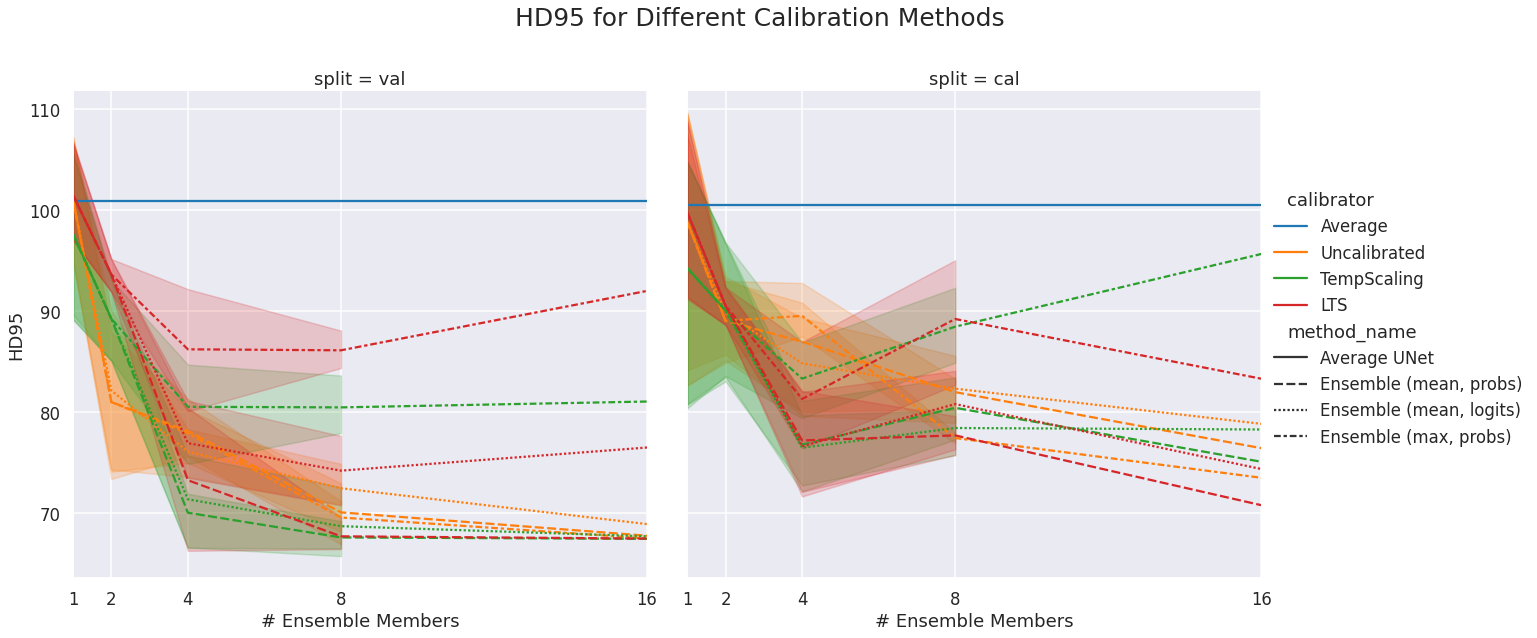

In [14]:
hd_metric_df = group_by_config(image_info_df[image_info_df['image_metric'] == 'HD95'])

g = sns.relplot(
    data=hd_metric_df,
    x="num_ensemble_members",
    y="metric_score",
    hue="calibrator",
    style="method_name",
    kind="line",
    col="split",
    height=9,
)
# Set the title of the bar plot
g.fig.suptitle("HD95 for Different Calibration Methods", fontsize=25)
g.fig.subplots_adjust(top=0.85)
# Separate the columns slightly
g.fig.subplots_adjust(wspace=0.07)
# Change the y axis label
g.set_ylabels("HD95")
g.set_xlabels("# Ensemble Members")
g.set(xlim=(1, 16))
g.set(xticks=[1, 2, 4, 8, 16])

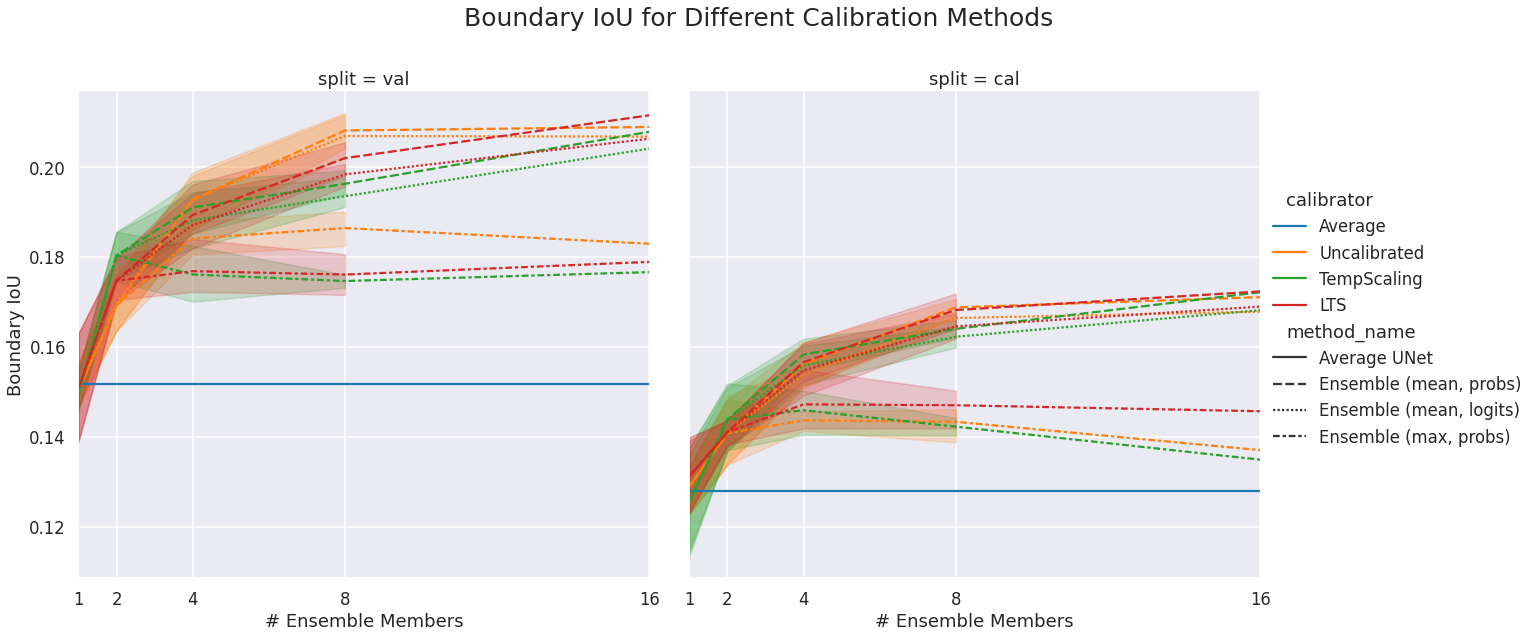

In [15]:
boundary_metric_df = group_by_config(image_info_df[image_info_df['image_metric'] == 'BoundaryIOU'])

g = sns.relplot(
    data=boundary_metric_df,
    x="num_ensemble_members",
    y="metric_score",
    hue="calibrator",
    style="method_name",
    kind="line",
    col="split",
    height=9,
)
# Set the title of the bar plot
g.fig.suptitle("Boundary IoU for Different Calibration Methods", fontsize=25)
g.fig.subplots_adjust(top=0.85)
# Separate the columns slightly
g.fig.subplots_adjust(wspace=0.07)
# Change the y axis label
g.set_ylabels("Boundary IoU")
g.set_xlabels("# Ensemble Members")
g.set(xlim=(1, 16))
g.set(xticks=[1, 2, 4, 8, 16])

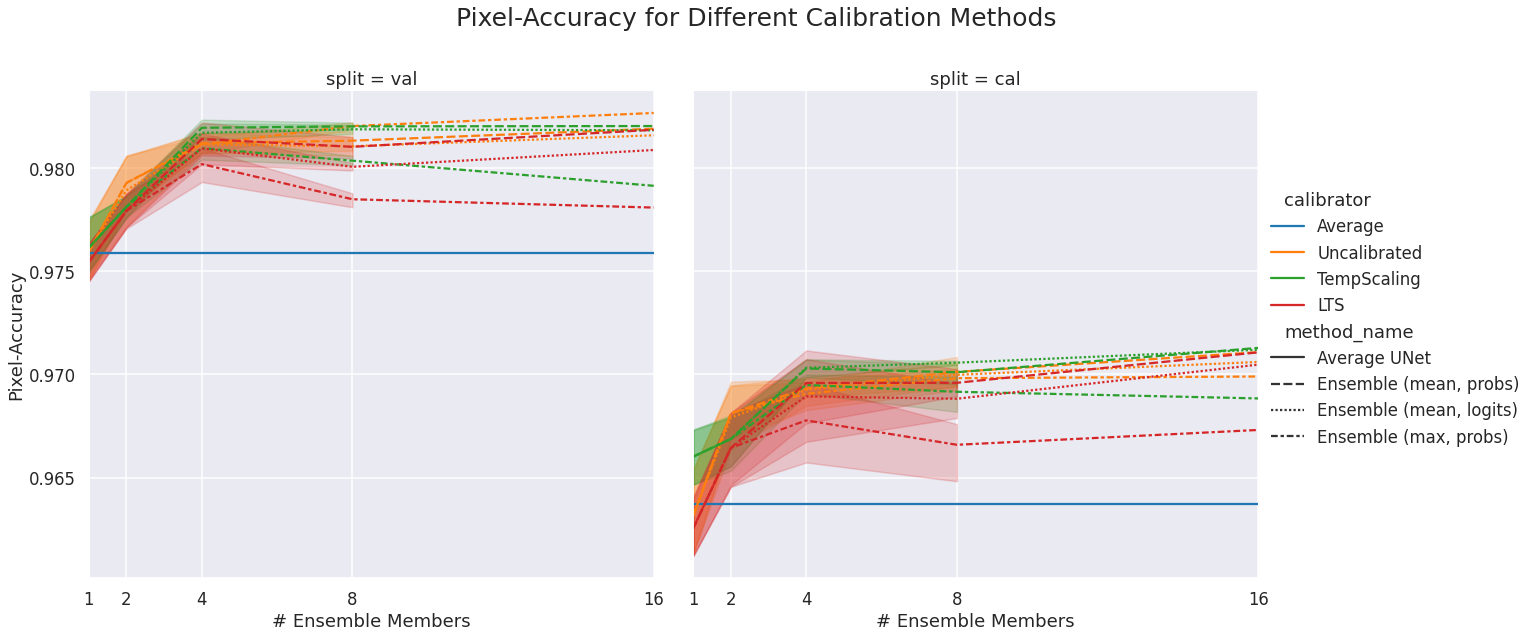

In [16]:
boundary_metric_df = group_by_config(image_info_df[image_info_df['image_metric'] == 'Accuracy'])

g = sns.relplot(
    data=boundary_metric_df,
    x="num_ensemble_members",
    y="metric_score",
    hue="calibrator",
    style="method_name",
    kind="line",
    col="split",
    height=9,
)
# Set the title of the bar plot
g.fig.suptitle("Pixel-Accuracy for Different Calibration Methods", fontsize=25)
g.fig.subplots_adjust(top=0.85)
# Separate the columns slightly
g.fig.subplots_adjust(wspace=0.07)
# Change the y axis label
g.set_ylabels("Pixel-Accuracy")
g.set_xlabels("# Ensemble Members")
g.set(xlim=(1, 16))
g.set(xticks=[1, 2, 4, 8, 16])